In [2]:
#data cleaning imports
import pandas as pd
import numpy as np

#regression model imports
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA

#graphic import
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#transformed data download import
import base64
from IPython.display import HTML

df = pd.read_csv('hotel_bookings.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
df.shape

(119390, 32)

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
#Calculated sparsity 
total = df.shape[0]*df.shape[1]
missing = df.isnull().sum().sum()
percent = missing/float(total)

percent

0.03387663330262166

In [7]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [8]:
#explore company and agent descriptive statistics for imputation of nulls
display(df[['company','agent']].describe())

,company,agent
count,6797.000000,103050.000000
mean,189.266735,86.693382
std,131.655015,110.774548
min,6.000000,1.000000
25%,62.000000,9.000000
50%,179.000000,14.000000
75%,270.000000,229.000000
max,543.000000,535.000000


In [9]:
#transform company and agent to a binary attribute of {individual:0, company:1} and {no_agent:0, agent:1}
df["company"].fillna(0, inplace = True)
df.loc[(df['company']>5), 'company'] = 1
df["agent"].fillna(0, inplace = True)
df.loc[(df['agent']>=1), 'agent'] = 1

In [10]:
# How many adults and babies are there for those with null children entries

display(df.loc[df['children'].isnull(), 'babies'])
display(df.loc[df['children'].isnull(), 'adults'])

40600    0
40667    0
40679    0
41160    0
Name: babies, dtype: int64

40600    2
40667    2
40679    3
41160    2
Name: adults, dtype: int64

In [11]:
# What are the statistical distributions for groups of adults with 2 people and 0 babies
# Then impute the average of the children qty of those subgroups into the null for children
# For multivariate imputation

# Adults group size 2, children distribution
display(df.loc[df['adults']==2, 'children'].describe())
display(df.loc[df['adults']==3, 'children'].describe())

# Groups with zero babies, children distribution
display(df.loc[df['babies']==0, 'children'].describe())



count    89677.000000
mean         0.120187
std          0.428097
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: children, dtype: float64

count    6201.000000
mean        0.091114
std         0.308879
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: children, dtype: float64

count    118469.000000
mean          0.102947
std           0.397583
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: children, dtype: float64

In [12]:
# Considering that the the column babies has, not null, but 0 as an entry and that the greater majority of distributions 
# of groups of 2 and 3 adults having 0 children, 0 will be imputed into the four null values.

df.loc[df['children'].isnull(), 'children'] = 0

df.children.isnull().sum()

0

In [13]:
df = df.drop(['country'], axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [16]:
df.lead_time.describe()

count    119390.000000
mean        104.011416
std         106.863097
min           0.000000
25%          18.000000
50%          69.000000
75%         160.000000
max         737.000000
Name: lead_time, dtype: float64

# Transform

In [14]:
dfc = df.copy()

In [193]:
#This will create a binary encoding for variable hotel
dfc['hotel'] = dfc['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

#This will create a numerical mapping of arrival_date_month
dfc['arrival_date_month'] = dfc['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
le = LabelEncoder()

dfc = dfc.apply(le.fit_transform)

display(dfc.info())
display(dfc.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   hotel                           119390 non-null  int64
 1   is_canceled                     119390 non-null  int64
 2   lead_time                       119390 non-null  int64
 3   arrival_date_year               119390 non-null  int64
 4   arrival_date_month              119390 non-null  int64
 5   arrival_date_week_number        119390 non-null  int64
 6   arrival_date_day_of_month       119390 non-null  int64
 7   stays_in_weekend_nights         119390 non-null  int64
 8   stays_in_week_nights            119390 non-null  int64
 9   adults                          119390 non-null  int64
 10  children                        119390 non-null  int64
 11  babies                          119390 non-null  int64
 12  meal                            119390 non-n

None

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,...,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.664461,0.370416,103.348497,1.156554,5.552483,26.165173,14.798241,0.927414,2.499447,1.854268,...,0.124893,0.863138,0.056931,1.815939,2.137323,3533.933219,0.062451,0.571363,0.649803,516.750147
std,0.472181,0.482918,104.438615,0.707476,3.090619,13.605138,8.780829,0.996148,1.894431,0.495897,...,0.334678,0.343703,0.231712,11.634394,0.577040,2142.330517,0.243664,0.792798,0.497776,227.476419
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,18.000000,1.000000,3.000000,15.000000,7.000000,0.000000,1.000000,2.000000,...,0.000000,1.000000,0.000000,0.000000,2.000000,1773.000000,0.000000,0.000000,0.000000,336.000000
50%,1.000000,0.000000,69.000000,1.000000,6.000000,27.000000,15.000000,1.000000,2.000000,2.000000,...,0.000000,1.000000,0.000000,0.000000,2.000000,3337.500000,0.000000,0.000000,1.000000,524.000000
75%,1.000000,1.000000,160.000000,2.000000,8.000000,37.000000,22.000000,2.000000,3.000000,2.000000,...,0.000000,1.000000,0.000000,0.000000,2.000000,5068.000000,0.000000,1.000000,1.000000,709.000000
max,1.000000,1.000000,478.000000,2.000000,11.000000,52.000000,30.000000,16.000000,34.000000,13.000000,...,2.000000,1.000000,1.000000,127.000000,3.000000,8878.000000,4.000000,5.000000,2.000000,925.000000


In [194]:
#split the numeric and categorical columns into lists for the StandardScaler later
numeric = ['lead_time','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies','previous_cancellations','previous_bookings_not_canceled','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests']
categorical = list(set(dfc.columns) - set(numeric) - {'is_canceled'})
categorical.sort()

print(numeric)
print('\n')
print(categorical)


['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


['agent', 'arrival_date_day_of_month', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_year', 'assigned_room_type', 'company', 'customer_type', 'deposit_type', 'distribution_channel', 'hotel', 'is_repeated_guest', 'market_segment', 'meal', 'reservation_status', 'reservation_status_date', 'reserved_room_type']


In [195]:
#train/test split with 20% sampling and a random state of 5 to avoid bootlegging.

train_1, test_1 = train_test_split(dfc, test_size=0.2, random_state = 5, stratify=dfc['is_canceled'])


print(train_1.shape)
print(test_1.shape)
print('\n')
print(train_1['is_canceled'].value_counts(normalize=True))
print('\n')
print(test_1['is_canceled'].value_counts(normalize=True))

(95512, 31)
(23878, 31)


0    0.629586
1    0.370414
Name: is_canceled, dtype: float64


0    0.629575
1    0.370425
Name: is_canceled, dtype: float64


In [196]:
s = StandardScaler()

df_scaler = s.fit(train_1[numeric])

def features(dfc, numeric, categorical, df_scaler):
    X_numeric_scaled = df_scaler.transform(dfc[numeric])
    X_categorical = dfc[categorical].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = dfc['is_canceled']
    return X, y

X, y = features(train_1, numeric, categorical, df_scaler)

# First Regression Model

In [197]:
dfc_1_log = LogisticRegression(penalty='none',solver='newton-cg',random_state=0, multi_class='multinomial',max_iter = 500)
dfc_1_log.fit(X, y)

C:\Users\Owner\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [198]:
X_test, y_test = features(test_1, numeric, categorical, df_scaler)

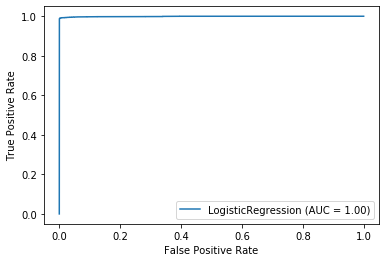

In [199]:
#plot ROC curve
plot_roc_curve(dfc_1_log, X_test, y_test)

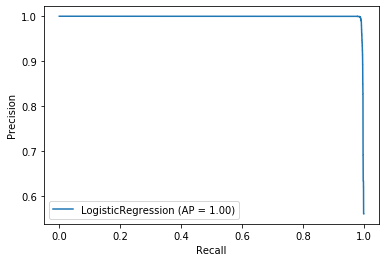

In [200]:
#plot precision recall curve
plot_precision_recall_curve(dfc_1_log, X_test, y_test)

In [201]:
#Confusion Matrix

y_pred = dfc_1_log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[15026     7]
 [  123  8722]]


In [115]:
#make predictions for accuracy and AUC scores
test_prob = dfc_1_log.predict_proba(X_test)[:, 1]
test_pred = dfc_1_log.predict(X_test)

print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))

AUC = 0.99901
Accuracy = 0.99456


In [116]:
#get parameters of the model, y-intercepts, and coefficients

predictions = dfc_1_log.predict(x_test)
parameters = dfc_1_log.get_params()
display(parameters)
display('y-int: \n', dfc_1_log.intercept_)
display('Coefficients: \n', dfc_1_log.coef_)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

'y-int: \n'

array([-115.28339475])

'Coefficients: \n'

array([[-1.07067324e-01,  1.74423156e+00,  5.28915463e+01,
         1.21437271e+00,  6.98010498e+02, -5.88139389e-02,
        -2.21623961e-01,  8.79889678e-02,  2.81113411e-01,
        -1.60650040e-02,  2.48729805e-01, -5.09626994e-01,
        -3.18522426e-02, -5.34308060e-02, -6.95193866e-02,
        -1.90919428e+00,  7.35486920e-02, -1.33939233e-01,
         6.41632877e-01,  2.01792105e+00, -2.30340625e-02,
         6.37646559e-03, -2.98307377e-03,  2.91498198e-02,
        -1.66483516e-02, -1.04348781e-01, -5.84351412e-02,
        -1.04845311e-01, -2.00497821e+00, -3.59085500e-02]])

### One-way ANOVA Test

In [117]:
#for those variables with p-values less than .05 we reject the null hypothesis 
for x in categorical:
    m = ols('is_canceled' + '~' + x, data = dfc).fit() #OLS
    result = sm.stats.anova_lm(m) # ANOVA 
    print(result)

                df        sum_sq     mean_sq            F         PR(>F)
agent          1.0    290.060636  290.060636  1256.857674  7.205191e-274
Residual  119388.0  27552.649675    0.230782          NaN            NaN
                                 df        sum_sq   mean_sq         F  \
arrival_date_day_of_month       1.0      1.046270  1.046270  4.486515   
Residual                   119388.0  27841.664041  0.233203       NaN   

                             PR(>F)  
arrival_date_day_of_month  0.034165  
Residual                        NaN  
                          df        sum_sq   mean_sq          F   PR(>F)
arrival_date_month       1.0      3.382324  3.382324  14.504981  0.00014
Residual            119388.0  27839.327987  0.233184        NaN      NaN
                                df        sum_sq   mean_sq         F    PR(>F)
arrival_date_week_number       1.0      1.848505  1.848505  7.926811  0.004872
Residual                  119388.0  27840.861806  0.233196       NaN  

# Dimensionality Reduction via Principal Component Analysis

### Correlation to Target Variable is_cancelled 

First, all independent variables should be assessed for correlation to the target variable is_canceled. This may help in dimensionality reduction for determining uneccessary elements in the dataset.

In [125]:
#display correllation to the target variable for each variable
df_corr = dfc[dfc.columns[0:100]].corr()['is_canceled'][:-1].sort_values()
df_corr.sort_values()

reservation_status               -0.917196
total_of_special_requests        -0.234658
required_car_parking_spaces      -0.196593
assigned_room_type               -0.176028
booking_changes                  -0.144474
company                          -0.099310
is_repeated_guest                -0.084793
customer_type                    -0.068140
reserved_room_type               -0.061282
previous_bookings_not_canceled   -0.057358
babies                           -0.034133
meal                             -0.017678
arrival_date_day_of_month        -0.006130
stays_in_weekend_nights          -0.001706
children                          0.004883
arrival_date_week_number          0.008148
arrival_date_month                0.011022
arrival_date_year                 0.016660
stays_in_week_nights              0.025145
adr                               0.048726
market_segment                    0.059338
adults                            0.064491
days_in_waiting_list              0.066820
agent      

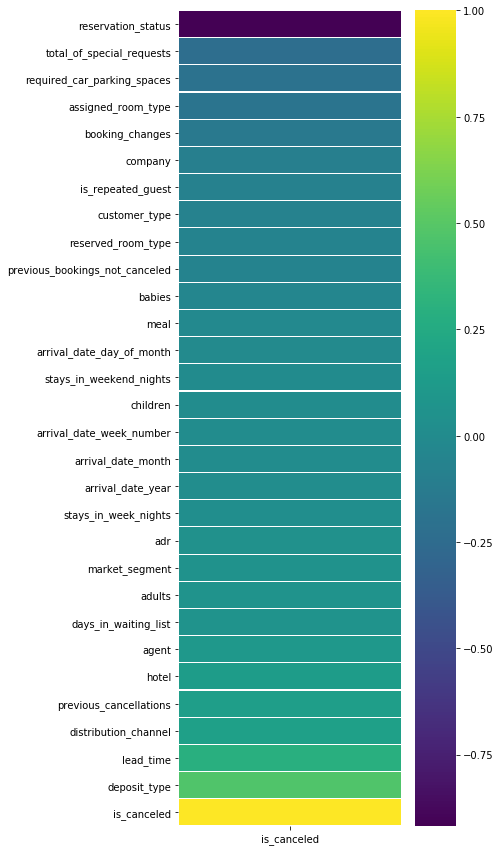

In [126]:
#visualize correlation to target variable is_canceled
fig, ax = plt.subplots(figsize=(5, 15))
sns.heatmap(df_corr.to_frame(),cmap="viridis", label = 'small',linewidths = .1)
plt.show();

### Principal Component Analsyis (PCA)

##### Determine Variance, Covariance, Eigenvalues, Eigenvectors and total variance accounted for by each variable in the dataset.

In [132]:
#PCA works namely with numerical data, so we will be using the numerical data from the initital dataset df.
#Then, the data will be transformed using the StandardScaler and each of the above pieces listed above determined.


#Variance and Covariance
scaled = StandardScaler().fit_transform(df[numeric])

display(scaled[:13])
variables = scaled.T
covariance_matrix = np.cov(variables)
display(covariance_matrix[:13])

array([[ 2.22705112, -0.92889042, -1.31023993,  0.24789727, -0.26065863,
        -0.08157926, -0.10317951, -0.09155477,  4.26010095, -0.1319236 ,
        -2.0150382 , -0.25487288, -0.72069411],
       [ 5.9233847 , -0.92889042, -1.31023993,  0.24789727, -0.26065863,
        -0.08157926, -0.10317951, -0.09155477,  5.79313122, -0.1319236 ,
        -2.0150382 , -0.25487288, -0.72069411],
       [-0.90781407, -0.92889042, -0.78620716, -1.47844749, -0.26065863,
        -0.08157926, -0.10317951, -0.09155477, -0.33898986, -0.1319236 ,
        -0.53093528, -0.25487288, -0.72069411],
       [-0.85166723, -0.92889042, -0.78620716, -1.47844749, -0.26065863,
        -0.08157926, -0.10317951, -0.09155477, -0.33898986, -0.1319236 ,
        -0.53093528, -0.25487288, -0.72069411],
       [-0.84230942, -0.92889042, -0.2621744 ,  0.24789727, -0.26065863,
        -0.08157926, -0.10317951, -0.09155477, -0.33898986, -0.1319236 ,
        -0.07581038, -0.25487288,  0.54066585],
       [-0.84230942, -0.928890

array([[ 1.00000838e+00,  8.56718505e-02,  1.65800753e-01,
         1.19519694e-01, -3.76131311e-02, -2.09151915e-02,
         8.60425226e-02, -7.35487840e-02,  1.48831319e-04,
         1.70085609e-01, -6.30773808e-02, -1.16451546e-01,
        -9.57128505e-02],
       [ 8.56718505e-02,  1.00000838e+00,  4.98972998e-01,
         9.18717896e-02,  4.57942689e-02,  1.84829653e-02,
        -1.27747259e-02, -4.27155927e-02,  6.32818459e-02,
        -5.41515671e-02,  4.93423193e-02, -1.85539646e-02,
         7.26714392e-02],
       [ 1.65800753e-01,  4.98972998e-01,  1.00000838e+00,
         9.29762914e-02,  4.42037235e-02,  2.01911435e-02,
        -1.39925481e-02, -4.87429578e-02,  9.62102518e-02,
        -2.01982702e-03,  6.52380267e-02, -2.48596310e-02,
         6.81923529e-02],
       [ 1.19519694e-01,  9.18717896e-02,  9.29762914e-02,
         1.00000838e+00,  3.04406145e-02,  1.81457939e-02,
        -6.73815258e-03, -1.07984077e-01, -5.16732063e-02,
        -8.28341680e-03,  2.30643147e

In [155]:
#Eigenvalues and Eigenvectors

values, vectors = np.linalg.eig(covariance_matrix)
display(values[:14])
display(vectors[:14])

array([1.7594412 , 1.50952015, 0.48975134, 0.60034476, 1.24637208,
       0.73274323, 0.75707659, 1.11358905, 1.06720678, 1.0208854 ,
       0.86457431, 0.8892939 , 0.94931009])

array([[ 9.51455704e-02,  4.94938312e-01, -1.40120377e-01,
         2.04970081e-01,  2.44203585e-01, -6.86612932e-01,
         2.44682637e-02, -2.29892033e-01,  2.55690713e-01,
         4.45111949e-02, -1.05254186e-01, -1.45965540e-01,
         8.47412417e-03],
       [ 4.71334881e-01,  3.28503930e-01, -6.74688369e-01,
        -1.06115907e-01, -2.90423430e-01,  1.50554038e-01,
        -4.61718351e-05,  8.33298583e-02, -2.06075052e-01,
        -6.64573755e-02,  1.81217196e-01,  8.54178829e-02,
         4.98805184e-02],
       [ 4.82272022e-01,  3.77969227e-01,  7.10104623e-01,
         1.10860233e-01, -2.49144609e-01,  4.79339933e-02,
         6.05207998e-04,  4.94693782e-02, -8.84592563e-02,
        -8.89154553e-02,  1.13018182e-01,  9.02178059e-02,
         6.74740278e-02],
       [ 3.32056582e-01, -1.01254200e-03,  6.42095518e-02,
        -4.16938744e-01,  3.90470676e-01,  2.05229000e-01,
         3.87427998e-01, -2.11263985e-01, -8.56577085e-02,
         4.47889901e-01, -1.98083451e

In [156]:
#calculate variance accounted for per numeric independent variable

var = []
for i in range(len(values)):
    var.append(values[i] / np.sum(values))
display(np.sum(var), var)

0.9999999999999999

[0.1353404972652541,
 0.11611596179029063,
 0.03767286472766409,
 0.04617997947948367,
 0.09587397245296526,
 0.05636439176917521,
 0.058236172914872944,
 0.08565997890841094,
 0.08209214196800081,
 0.07852898812515711,
 0.06650515890787705,
 0.06840665047052397,
 0.07302324122032414]

In [157]:
# Calculate Total Variance Captured by Principal Components
var = []
for i in range(len(values)):
    if values[i] >= .86:
        var.append(values[i] / np.sum(values))
display(np.sum(var), var)

0.8015465911088039

[0.1353404972652541,
 0.11611596179029063,
 0.09587397245296526,
 0.08565997890841094,
 0.08209214196800081,
 0.07852898812515711,
 0.06650515890787705,
 0.06840665047052397,
 0.07302324122032414]

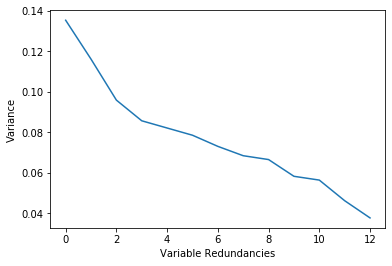

In [158]:
#Scree Plot For elbow method dimensionality reduction
pa = PCA(n_components=df[numeric].shape[1])
pa.fit(scaled)
df_pc = pd.DataFrame(pa.transform(df[numeric]),columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13'])
plt.plot(pa.explained_variance_ratio_)
plt.xlabel('Variable Redundancies')
plt.ylabel('Variance')
plt.show();

#### Using a combination of the Kaiser Criterion and individual variance methods, those values which will not be reduced by the PCA are those with an eigenvalue greater than .86. This will ensure that 80% of the variance is accoutned for.

# New Regression Model with Reduced Dimensions

### Those independent variables to be kept in accordance with the PCA and correlation matrix findings are:

#### Numeric (by PCA)

- Lead Time
- Stays in Weekend Nights
- Previous Cancellations
- Previous Bookings not Cancelled
- Booking Changes
- Days on Waiting List
- ADR
- Required Car Parking Spaces
- Total Number of Special Requests

#### Categorical (by correlation to is_cancelled)

- Deposit Type
- Distribution Channel
- Hotel
- Agent
- Market Segment
- Arrival Date (month, day, year, week number)

In [159]:
df.columns.to_list()

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

In [170]:
df_reduced = df[['is_canceled','lead_time','stays_in_weekend_nights','previous_cancellations','previous_bookings_not_canceled','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests','deposit_type','distribution_channel','hotel','agent','market_segment','arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month', 'children']]

df_reduced['hotel'] = df_reduced['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

#This will create a numerical mapping of arrival_date_month
df_reduced['arrival_date_month'] = df_reduced['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
le = LabelEncoder()
df_reduced = df_reduced.apply(le.fit_transform)


#display correllation to the target variable for each variable
df_corr = df_reduced[df_reduced.columns[0:100]].corr()['is_canceled'][:-1].sort_values()
df_corr.sort_values()

C:\Users\Owner\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Owner\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


total_of_special_requests        -0.234658
required_car_parking_spaces      -0.196593
booking_changes                  -0.144474
previous_bookings_not_canceled   -0.057358
arrival_date_day_of_month        -0.006130
stays_in_weekend_nights          -0.001706
arrival_date_week_number          0.008148
arrival_date_month                0.011022
arrival_date_year                 0.016660
adr                               0.048726
market_segment                    0.059338
days_in_waiting_list              0.066820
agent                             0.102068
hotel                             0.136531
previous_cancellations            0.153201
distribution_channel              0.167600
lead_time                         0.294009
deposit_type                      0.468634
is_canceled                       1.000000
Name: is_canceled, dtype: float64

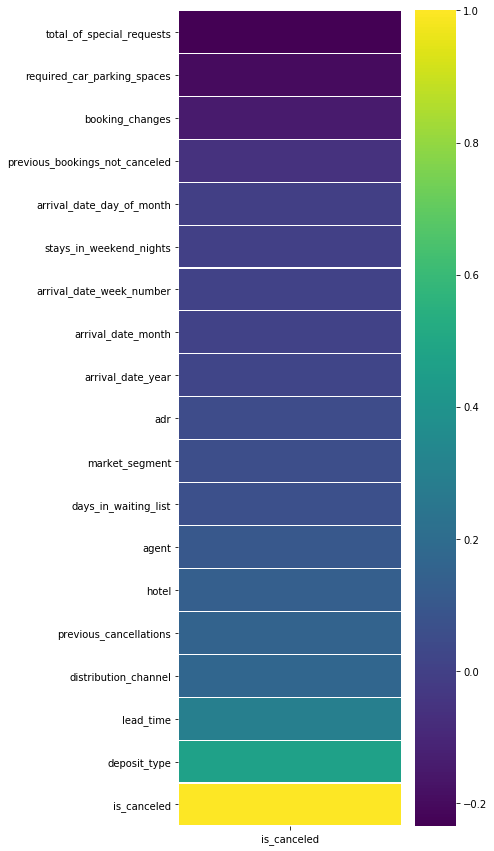

In [171]:
#visualize reduced dataset correlation to target variable is_canceled
fig, ax = plt.subplots(figsize=(5, 15))
sns.heatmap(df_corr.to_frame(),cmap="viridis", label = 'small',linewidths = .1)
plt.show();

### Repeat Model Creation Process

In [172]:
#split the numeric and categorical columns into lists for the StandardScaler later
numeric = ['lead_time','stays_in_weekend_nights','children','previous_cancellations','previous_bookings_not_canceled','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests']
categorical = list(set(df_reduced.columns) - set(numeric) - {'is_canceled'})
categorical.sort()


print(numeric)
print('\n')
print(categorical)


['lead_time', 'stays_in_weekend_nights', 'children', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


['agent', 'arrival_date_day_of_month', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_year', 'deposit_type', 'distribution_channel', 'hotel', 'market_segment']


In [173]:
#train/test split with 20% sampling and a random state of 5 to avoid bootlegging.

train_1, test_1 = train_test_split(df_reduced, test_size=0.2, random_state = 5, stratify=df_reduced['is_canceled'])


print(train_1.shape)
print(test_1.shape)
print('\n')
print(train_1['is_canceled'].value_counts(normalize=True))
print('\n')
print(test_1['is_canceled'].value_counts(normalize=True))

(95512, 20)
(23878, 20)


0    0.629586
1    0.370414
Name: is_canceled, dtype: float64


0    0.629575
1    0.370425
Name: is_canceled, dtype: float64


In [176]:
s = StandardScaler()
df_scaler = s.fit(train_1[numeric])

def features(df_reduced, numeric, categorical, df_scaler):
    X_numeric_scaled = df_scaler.transform(df_reduced[numeric])
    X_categorical = df_reduced[categorical].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df_reduced['is_canceled']
    return X, y

X, y = features(train_1, numeric, categorical, df_scaler)

### Second Model with Reduced Dimensions

In [177]:
dfc_2_log = LogisticRegression(penalty='none',solver='newton-cg',random_state=0, multi_class='multinomial',max_iter = 500)
dfc_2_log.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=0, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [178]:
X_test, y_test = features(test_1, numeric, categorical, df_scaler)

# Evaluate the Model

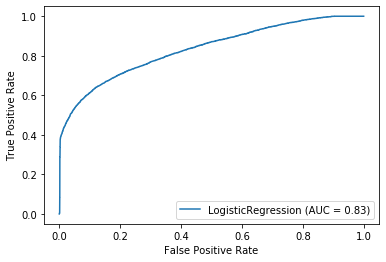

In [179]:
#plot ROC curve
plot_roc_curve(dfc_2_log, X_test, y_test)

In [181]:
#make predictions for accuracy and AUC scores
test_prob = dfc_2_log.predict_proba(X_test)[:, 1]
test_pred = dfc_2_log.predict(X_test)

print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))

AUC = 0.83286
Accuracy = 0.79609


In [183]:
#get parameters of the model, y-intercepts, and coefficients

predictions = dfc_2_log.predict(X_test)
parameters = dfc_2_log.get_params()
display(parameters)
display('y-int: \n', dfc_2_log.intercept_)
display('Coefficients: \n', dfc_2_log.coef_)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

'y-int: \n'

array([-2.71179007])

'Coefficients: \n'

array([[ 0.02302322,  0.00534902,  0.1513049 , -0.03329736,  0.10117951,
         2.24217341, -0.15767195, -0.01397723,  0.28435439,  0.14678861,
         0.04311929,  0.03700853,  0.83892636, -0.49625927, -0.1393198 ,
        -0.02094149,  0.11631507, -4.28835152, -0.25561069]])

In [184]:
#Confusion Matrix

y_pred = dfc_2_log.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[14254   779]
 [ 4090  4755]]
